# Testing de métricas utilizando grafos sintéticos

El objetivo principal de este documento es poner a prueba la coherencia o funcionalidad de cada una de las métricas de colaboración establecida y propuestas. 

Las herramientas con las que contamos son:
* `Random_Graphs_Nuevas_Conexiones` : 200 grafos donde la varía la probabilidad de que una conexión vaya a un nuevo nodo
* `Random_Graphs_Numero_Respuestas` : 200 grafos donde la varía el rango de número de respuestas que pueda dar un evaluador
* `Random_Graphs_Rango_Respondientes` : 200 grafos donde la varía el rango de número de evaluadores, o respondientes, posibles
* `Random_Graphs_Respondientes` : 200 grafos donde la varía la probabilidad de que una conexión vaya a un nuevo nodo

### Metodología

El proceso que seguiremos con cada una de las métricas de colaboración $\mathcal{C}_{i}$ consiste en:
* Tomar registro de cada uno de los grafos $G_{k}$
* Para cada variación, revisar que los 50 grafos que se espera que tengan mayos índice de colaboración se encuentren en el top 100 en términos del ranking en que deja $\mathcal{C}_{i}$ a los grafos sintéticos. 
* Se toma registro de cuántos de los 50 grafos cumplen con la condición explicada arriba.
* Aquellas métricas cuyo registro no baje de 0.95 son razonables para continuar nuestro estudio de colaboratividad.  

In [115]:
#-------------------------------------------------------
# Importar paquetes a utilizar
#-------------------------------------------------------
import pandas as pd
import numpy as np 
import networkx as nx
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import math


In [116]:
"""
#in this dictionary we collect the information for the 200 random graphs we generated
G={'Nuevas_Conexiones':[],'Numero_Respuestas':[], 'Rango_Respondientes':[], 'Respondientes':[]}

for key in G.keys():
    for i in range(200):
        G[key].append(nx.read_graphml('Random_Graphs_'+key+'/Random_Graph_'+key+str(i)+'.graphml'))
"""

"\n#in this dictionary we collect the information for the 200 random graphs we generated\nG={'Nuevas_Conexiones':[],'Numero_Respuestas':[], 'Rango_Respondientes':[], 'Respondientes':[]}\n\nfor key in G.keys():\n    for i in range(200):\n        G[key].append(nx.read_graphml('Random_Graphs_'+key+'/Random_Graph_'+key+str(i)+'.graphml'))\n"

In [117]:
#--------------------------------
# Central point of Dominance
#--------------------------------
# How centralized a graph is with respect to the metric betweenness centrality.

def central_point_dominance(G):
    betwennesses = nx.betweenness_centrality(G)
    b_max = max(betwennesses.values())
    N = len(betwennesses.keys())
    count = 0
    for i, b_i in betwennesses.items():
        count += ( b_max - b_i )/(N-1)
    return count

In [118]:
#--------------------------------
# Spectral Radius
#--------------------------------
#     the smaller the spectral radius rho, the higher the probability of 'virus infection' tau, 
#     the more difficult it is for an idea to spread in the innovative network, 
#     namely, the less efficient

import numpy.linalg

def spectral_radius(G):
    L = nx.normalized_laplacian_matrix(G)
    e = numpy.linalg.eigvals(L.A)
    e_abs = [abs(x) for x in e]
    return max(e_abs)

In [119]:
def core_ratio(G):
    return len(nx.k_core(G,k=2).nodes())/len(G.nodes())

In [120]:
def rich_club_coeffs(G):
    t_ok = True
    t = 0
    d = dict()
    while t_ok:
        nodes_large_degree=[]
        for x in G.nodes():
            if G.degree(x)>t:
                nodes_large_degree.append(x)
        core = G.subgraph(nodes_large_degree)
        edges_core = len(core.edges())
        nodes_core = len(core.nodes())
        if nodes_core<=1:
            t_ok = False
            break
        d[t] = (2*edges_core)/(nodes_core*(nodes_core-1))
        t += 1 
    return d        

def max_rich_club(G):
    #rich_club_1=nx.algorithms.rich_club_coefficient(G, normalized=False)
    rich_club=rich_club_coeffs(G)
    max_i=0
    for i in range(len(rich_club)):
        if rich_club[i]>rich_club[max_i]:
            max_i=i
        else:
            return rich_club[max_i]

In [121]:
def eccentricity(G):
    excentricidades=nx.algorithms.distance_measures.eccentricity(G)
    excentricidad=0
    for i in excentricidades.keys():
        excentricidad+=excentricidades[i]
    return excentricidad/len(excentricidades.keys())

In [122]:
def avg_responses(G):
    avg=0
    respondents=0
    resp_dictionary = nx.get_node_attributes(G, 'responses')
    for node in G.nodes():
        try:
            #avg += node['responses']
            avg += resp_dictionary[node]
            respondents += 1
        except:
            pass
    if respondents == 0:
        return 0
    return avg/respondents

In [123]:
def degree(G):
    return 2*len(G.edges())/len(G.nodes())

In [124]:
def modularity(G):
    return nx.algorithms.community.quality.performance(G,nx.algorithms.community.modularity_max.greedy_modularity_communities(G))

In [125]:
def clustering(G):
    total = 0
    count = 0
    for v in G.nodes():
        if nx.degree(G,v) >= 2:          #solo el clustering coeff de nodos con deg>=2
            total += nx.clustering(G,v)
            count += 1
    return total/count

## Creacion del Dataframe

El siguiente bloque crea todas las metricas de la grafica que usaremos para estudiarlas.

In [126]:
metric_function_map = {'Degree': degree,
            'Excentricidad': eccentricity,
            'Diametro': nx.diameter,
            'Radio':nx.radius,
            'Camino más corto promedio':nx.average_shortest_path_length,
            'Transitividad':nx.transitivity,
            'Eficiencia Global':nx.global_efficiency,
            'Rich Club Coefficient':max_rich_club,
            'Core Ratio':core_ratio,
            'Central Point Dominance':central_point_dominance,
            'Spectral radius':spectral_radius,
            'Modularidad':modularity,
            'Average Collaborations': avg_responses,
            'Clustering': clustering}

def measures(G):
    D = dict()
    for metric, function in metric_function_map.items():
        D[metric] = [function(nx.to_undirected(G))]
    return D

def embed(D1, D2):
    for key, value in D1.items():
        D2[key].append(value)
    return D2

def df_colaboraciones_test(keys,n=200):
    """
    keys es una lista de los atributos que queremos leer
    """

    dfs={}

    for key in keys:

        for index in range(n):
            graph=G[key][index]
            if index==0:
                dict_meas=measures(graph)
            new=measures(graph)
            for metric in metric_function_map.keys():
                dict_meas[metric]+=new[metric]

        dfs[key]=pd.DataFrame()
        for metric in metric_function_map.keys():
            dfs[key][metric]=dict_meas[metric]

    return dfs

In [127]:
"""
def df_colaboraciones_test(keys):
    
    #keys es una lista de los atributos que queremos leer
    

    n=200

    degree = {}
    diameter = {}
    radius = {}
    avg_shortest_path_length = {}
    transitivity = {}
    global_efficiency = {}
    modularity = {}
    rich_club_coefficient = {}
    core_rate= {}
    central_pt = {}
    spectral_radii = {}
    excentricidad = {}
    modularidad = {}
    responses = {}

    dfs={}

    for key in keys:

        degree[key] = n*[0]
        diameter[key] = n*[0]
        radius[key] = n*[0]
        avg_shortest_path_length[key] = n*[0]
        transitivity[key] = n*[0]
        global_efficiency[key] = n*[0]
        modularity[key] = n*[0]
        rich_club_coefficient[key] = n*[0]
        core_rate[key]= n*[0]
        central_pt[key] = n*[0]
        spectral_radii[key] = n*[0]
        excentricidad[key] = n*[0]
        modularidad[key] = n*[0]
        responses[key] = n*[0]

        for index in range(n):
            graph=G[key][index]
        
            #conseguimos cada parámetro para esta ciudad
            degree[key][index]=                        2*len(graph.edges())/len(graph.nodes())
            diameter[key][index] =                     nx.diameter(graph)
            radius[key][index] =                       nx.radius(graph)
            avg_shortest_path_length[key][index] =     nx.average_shortest_path_length(graph)
            transitivity[key][index] =                 nx.transitivity(graph)
            global_efficiency[key][index] =            nx.global_efficiency(graph)
            #modularidad precomputada
            rich_club_coefficient[key][index] =        max_rich_club(graph)  
            core_rate[key][index]=                     core_ratio(graph)
            central_pt[key][index]=                    central_point_dominance(graph)
            spectral_radii[key][index]=                spectral_radius(graph)
            excentricidad[key][index]=                 eccentricity(graph)
            modularidad[key][index]=                   nx.algorithms.community.quality.performance(graph,nx.algorithms.community.modularity_max.greedy_modularity_communities(graph))
            responses[key][index]=                     avg_responses(graph)

        dfs[key]=pd.DataFrame()

        dfs[key]['Eficiencia Global'] = global_efficiency[key]
        dfs[key]['Average Responses'] = responses[key]
        dfs[key]['Degree']= degree[key]
        dfs[key]['Transitividad'] = transitivity[key]
        dfs[key]['Modularidad'] = modularidad[key]
        dfs[key]['Excentricidad']= excentricidad[key]
        dfs[key]['Radio'] = radius[key]
        dfs[key]['Rich Club Coefficient'] = rich_club_coefficient[key]
        dfs[key]['Core Ratio'] = core_rate[key]
        dfs[key]['Central Point Dominance'] = [round(central_pt[key][index],3) for index in range(n)]
        dfs[key]['Spectral radius'] = [round(spectral_radii[key][index],3) for index in range(n)]
        dfs[key]['Camino más corto promedio'] = avg_shortest_path_length[key]
        dfs[key]['Diámetro'] = diameter[key]

    return dfs
"""

"\ndef df_colaboraciones_test(keys):\n    \n    #keys es una lista de los atributos que queremos leer\n    \n\n    n=200\n\n    degree = {}\n    diameter = {}\n    radius = {}\n    avg_shortest_path_length = {}\n    transitivity = {}\n    global_efficiency = {}\n    modularity = {}\n    rich_club_coefficient = {}\n    core_rate= {}\n    central_pt = {}\n    spectral_radii = {}\n    excentricidad = {}\n    modularidad = {}\n    responses = {}\n\n    dfs={}\n\n    for key in keys:\n\n        degree[key] = n*[0]\n        diameter[key] = n*[0]\n        radius[key] = n*[0]\n        avg_shortest_path_length[key] = n*[0]\n        transitivity[key] = n*[0]\n        global_efficiency[key] = n*[0]\n        modularity[key] = n*[0]\n        rich_club_coefficient[key] = n*[0]\n        core_rate[key]= n*[0]\n        central_pt[key] = n*[0]\n        spectral_radii[key] = n*[0]\n        excentricidad[key] = n*[0]\n        modularidad[key] = n*[0]\n        responses[key] = n*[0]\n\n        for index in

## Colaboracion

Empezamos analizando las metricas que ya hemos calculado y luego usaremos esta informacion para crear una medida de la colaboracion.

In [128]:
#have measured already
#df_colaboraciones_test(['Nuevas_Conexiones'])['Nuevas_Conexiones'].to_csv('Random_Nuevas_Conexiones.csv')
#df_colaboraciones_test(['Numero_Respuestas'])['Numero_Respuestas'].to_csv('Random_Numero_Respuestas.csv')
#df_colaboraciones_test(['Rango_Respondientes'])['Rango_Respondientes'].to_csv('Random_Rango_Respondientes.csv')
#df_colaboraciones_test(['Respondientes'])['Respondientes'].to_csv('Random_Respondientes.csv')


dfs = dict()
dfs['Nuevas_Conexiones'] = pd.read_csv('Random_Nuevas_Conexiones.csv')
dfs['Numero_Respuestas'] = pd.read_csv('Random_Numero_Respuestas.csv')
dfs['Rango_Respondientes'] = pd.read_csv('Random_Rango_Respondientes.csv')
dfs['Respondientes'] = pd.read_csv('Random_Respondientes.csv')

#for key in G.keys():
#    dfs[key] = pd.read_csv('Random_'+str(key)+'.csv')
#G={'Nuevas_Conexiones':[],'Numero_Respuestas':[], 'Rango_Respondientes':[], 'Respondientes':[]}



In [129]:
#---------------------------------------------
#Preparar escalas y herramientas para el analisis.
#---------------------------------------------

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X={}
normalized={}
pca={}
prin_comp={}

for key in dfs.keys():
    X[key]=dfs[key].to_numpy()

    normalized[key]= StandardScaler().fit_transform(X[key])
    pca[key]=PCA(n_components=5)
    prin_comp[key]=pca[key].fit_transform(normalized[key])

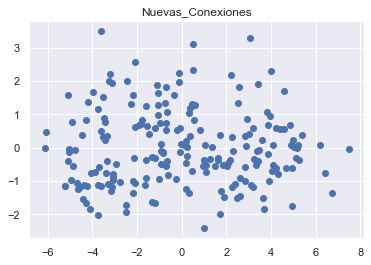

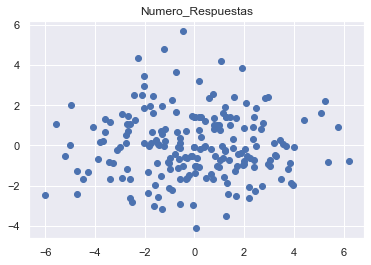

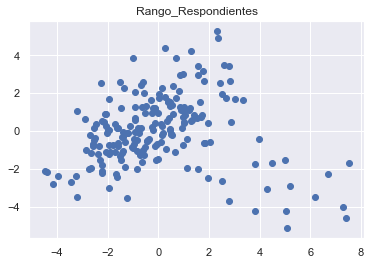

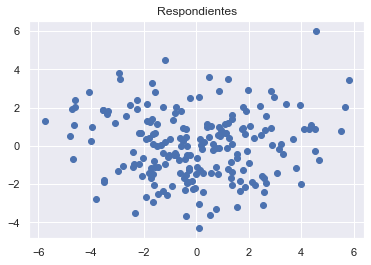

In [130]:
from matplotlib import pyplot as plt
for key in dfs.keys():
    f = plt.figure()
    plt.title(key)
    plt.scatter(prin_comp[key][:,0], prin_comp[key][:,1],color='b')

In [131]:
"""Formulas de Colaboracion"""

def colaborativity_formula_0(df):
    '''
    Original Collaborativity Formula during summer 2020 for project GED.
    Computes the colaborativity of a network G based on its measures, as shown below. 
    
    Input:
    - df : dataframe mapping each city to its graph metrics
    Returns:
    - Value describing the collaborativity of a graph, or network
    '''
    Avg_colabs =df['Average Collaborations']
    Clust = df['Clustering']
    Mod = df['Modularidad']
    return (1/2) * Avg_colabs * (Clust + (np.log10(Mod**2)*-1))


def colaborativity_formula_1(df):
    Efi = df['Eficiencia Global']
    Tran = df['Transitividad']
    Mod = df['Modularidad']
    Core = df['Core Ratio']
    return Efi + Tran + 1 - (Mod + Core)/2 


def colaborativity_formula_2(df):
    Efi = df['Eficiencia Global']
    Tran = df['Transitividad']
    Exc = df['Excentricidad']
    Mod = df['Modularidad']
    return Efi + Tran + (1/Exc) - Mod


def colaborativity_formula_3(df):
    efi = df['Eficiencia Global']   #comunicacion
    clus = df['Clustering']         #robustez
    mod = df['Modularidad']          #preparación para el futuro 
    return (efi * clus * (1+np.cos(math.pi*mod)) /2 )**(1/3)


def colaborativity_formula_4(df):
    efi = df['Eficiencia Global']    #comunicacion 
    tran = df['Transitividad']       #robustez
    mod = df['Modularidad']           #preparación para el futuro 
    return (efi * tran * (1+np.cos(math.pi*mod)) /2 )**(1/3)


def colaborativity_formula_5(df):
    efi = df['Eficiencia Global']    #comunicacion 
    tran = df['Transitividad']       #robustez
    core = df['Core Ratio']           #preparación para el futuro 
    return efi + tran + 1 - core 


def colaborativity_formula_6(df):
    efi = df['Eficiencia Global']    #comunicacion 
    tran = df['Transitividad']       #robustez
    exc = df['Excentricidad']        #preparación para el futuro 
    return (efi * tran * (np.sin(math.pi/exc)) )**(1/3)


# N e w    i d e a s    f o r   f o r m u l a s #

def quadratic(L):
    L_squared = [x**2 for x in L]
    return (np.mean(L_squared))**0.5


def colaborativity_formula_7(df):
    avg_deg = df['Average Collaborations']  #1 cantidad  
    efi = df['Eficiencia Global']    #2 calidad   comunicacion 
    tran = df['Transitividad']       #            robustez
    exc = df['Excentricidad']        #preparación para el futuro 
    #return 0.5*avg_deg  +  0.5*quadratic([efi , tran , (np.sin(math.pi/exc))])
    #return 0.5*avg_deg + 0.5*np.mean([efi , tran , (1/exc)])
    return 0.5*(np.log10(avg_deg+1)/np.log10(26)) + 0.5*(efi + tran + (1/exc))*(1/3)


def colaborativity_formula_8(df):
    avg_deg = df['Average Collaborations']  #1 cantidad  
    efi = df['Eficiencia Global']    #2 calidad   comunicacion 
    tran = df['Transitividad']       #            robustez
    mod = df['Modularidad']        #preparación para el futuro 
    return 0.5*(np.log10(avg_deg+1)/np.log10(26)) + 0.5*(1/3)*(efi + tran + 0.5*(1+np.cos(math.pi*mod)))


def colaborativity_formula_9(df):
    avg_deg = df['Average Collaborations']  #1 cantidad  
    efi = df['Eficiencia Global']    #2 calidad   comunicacion 
    tran = df['Transitividad']       #            robustez
    rcc = df['Rich Club Coefficient']        #preparación para el futuro 
    core = df['Core Ratio']        #preparación para el futuro 
    return 0.5*(np.log10(avg_deg+1)/np.log10(26)) + 0.5*(1/3)*(efi + tran + (rcc*core)**0.5)



def colaborativity_formula_10(df):
    avg_deg = df['Average Collaborations']  #1 cantidad  
    efi = df['Eficiencia Global']    #comunicacion 
    tran = df['Transitividad']       #robustez
    exc = df['Excentricidad']        #preparación para el futuro 
    return 0.5*(np.log10(avg_deg+1)/np.log10(26))+(efi * tran * (np.sin(math.pi/exc)) )**(1/3)

Coherence of Colaborativity Formulas w.r.t. to variance in Nuevas_Conexiones
Colab 0: 0.975
Colab 1: 0.975
Colab 2: 1.0
Colab 3: 1.0
Colab 4: 1.0
Colab 5: 0.7
Colab 6: 1.0
Colab 7: 0.975
Colab 8: 0.95
Colab 9: 0.975
Colab 10: 1.0
---------------------
Coherence of Colaborativity Formulas w.r.t. to variance in Numero_Respuestas
Colab 0: 0.525
Colab 1: 0.45
Colab 2: 0.625
Colab 3: 0.475
Colab 4: 0.55
Colab 5: 0.35
Colab 6: 0.55
Colab 7: 0.525
Colab 8: 0.575
Colab 9: 0.575
Colab 10: 0.6


/Users/olga/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


---------------------
Coherence of Colaborativity Formulas w.r.t. to variance in Rango_Respondientes
Colab 0: 0.375
Colab 1: 0.325
Colab 2: 0.3
Colab 3: 0.35
Colab 4: 0.4
Colab 5: 0.375
Colab 6: 0.25
Colab 7: 0.325
Colab 8: 0.375
Colab 9: 0.325
Colab 10: 0.325
---------------------
Coherence of Colaborativity Formulas w.r.t. to variance in Respondientes
Colab 0: 0.55
Colab 1: 0.875
Colab 2: 0.825
Colab 3: 0.575
Colab 4: 0.675
Colab 5: 0.925
Colab 6: 0.9
Colab 7: 0.725
Colab 8: 0.7
Colab 9: 0.7
Colab 10: 0.9
---------------------


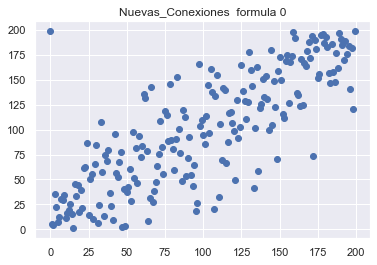

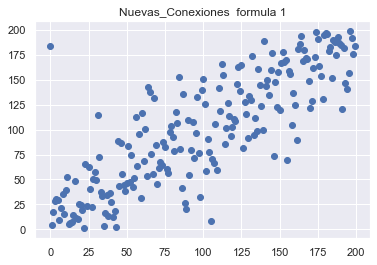

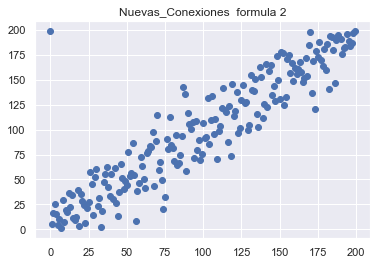

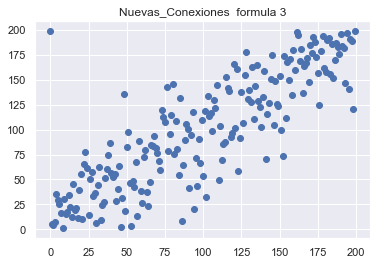

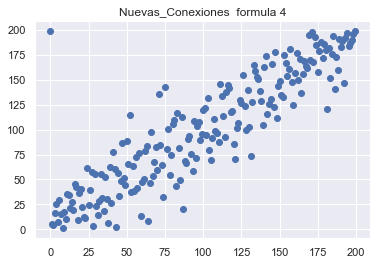

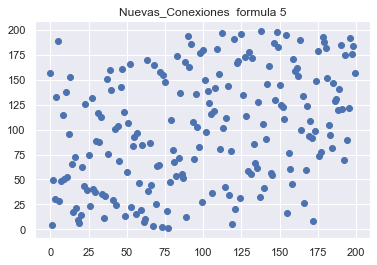

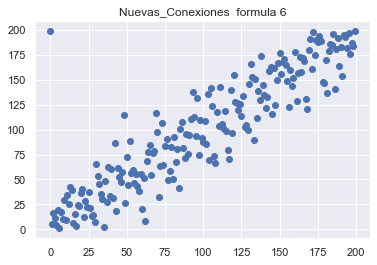

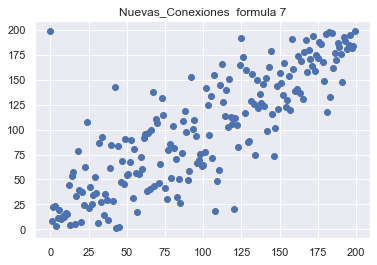

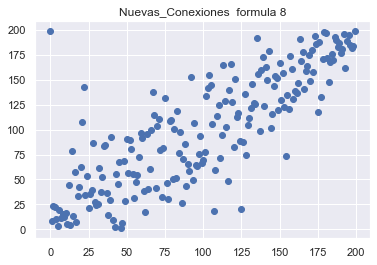

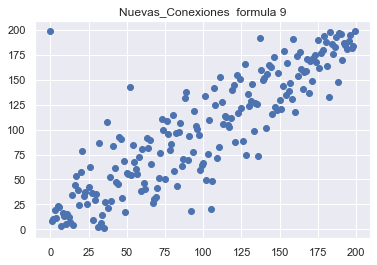

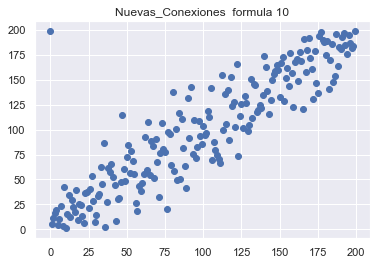

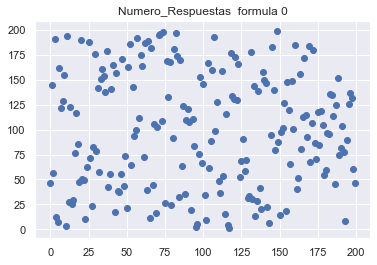

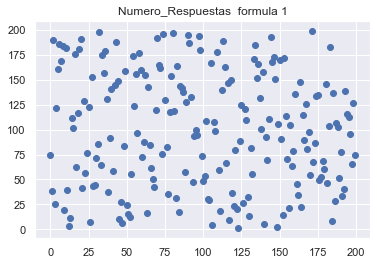

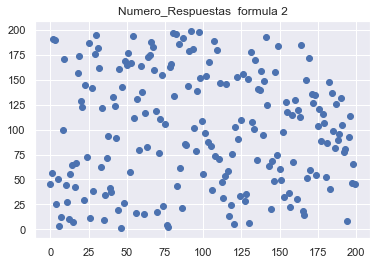

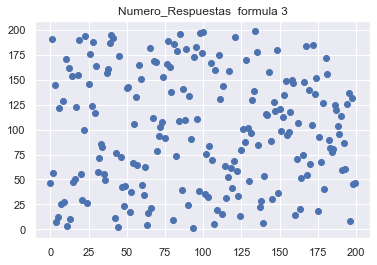

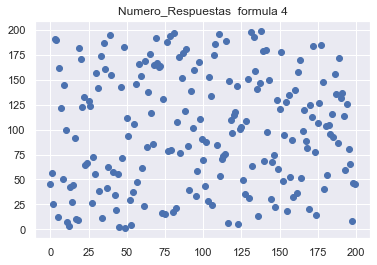

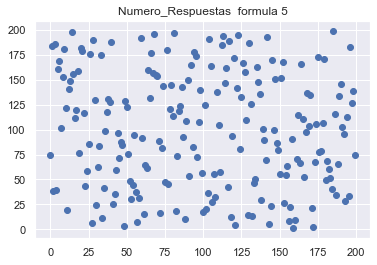

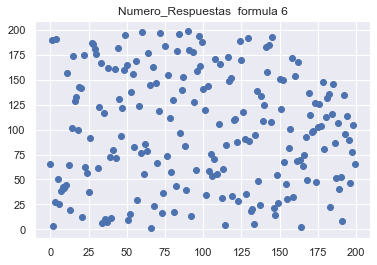

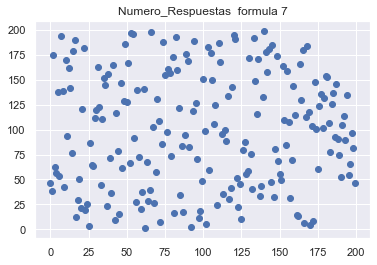

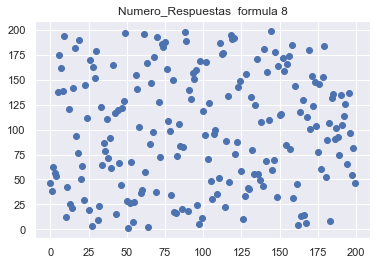

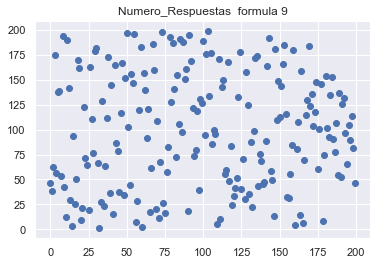

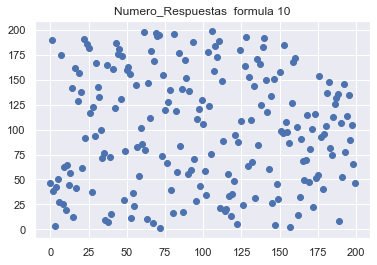

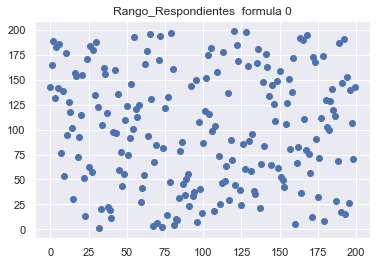

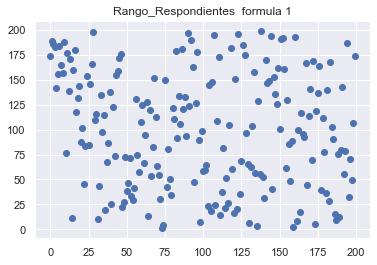

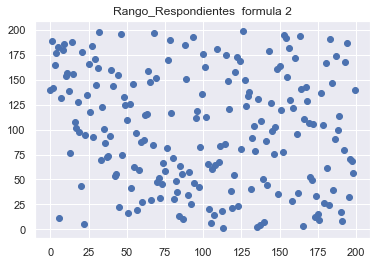

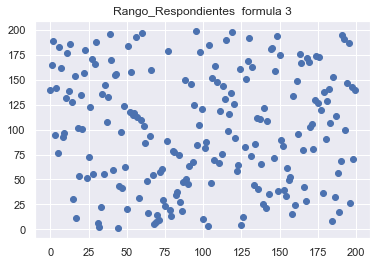

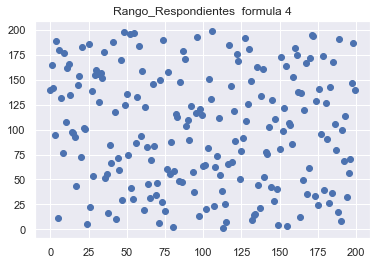

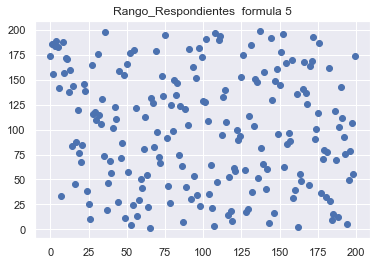

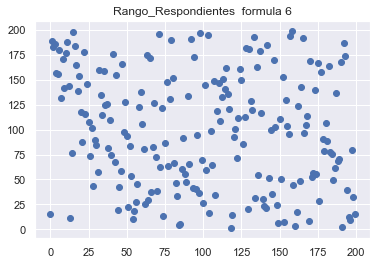

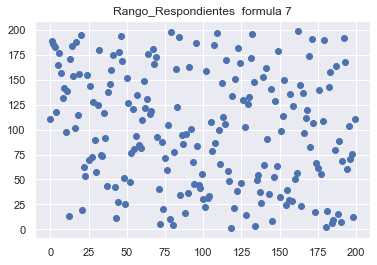

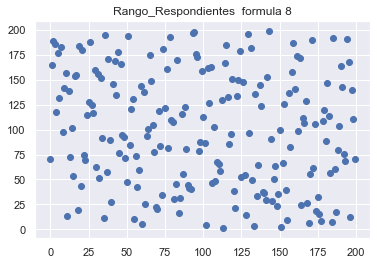

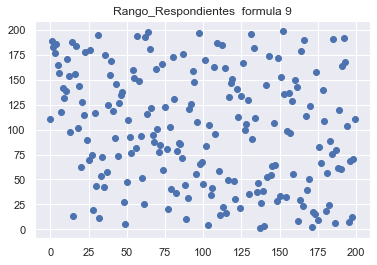

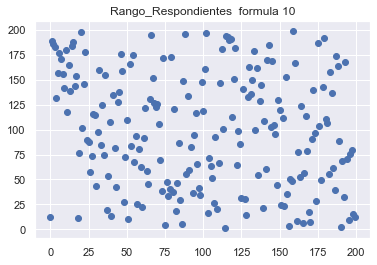

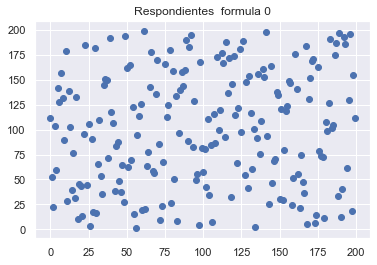

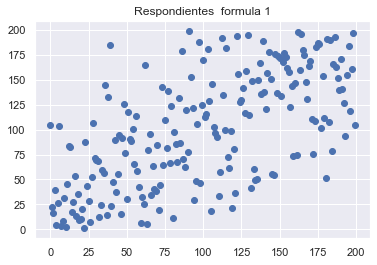

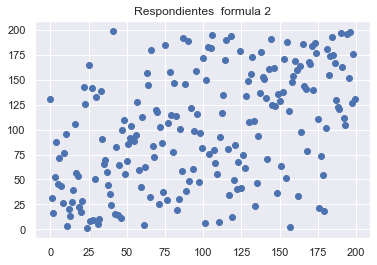

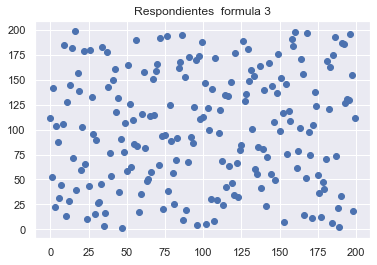

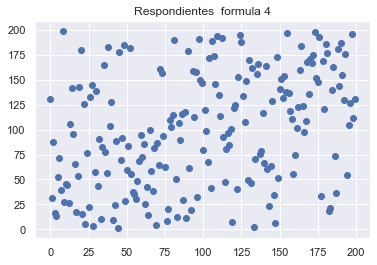

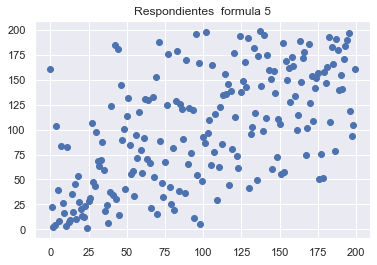

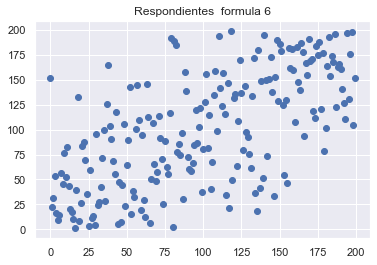

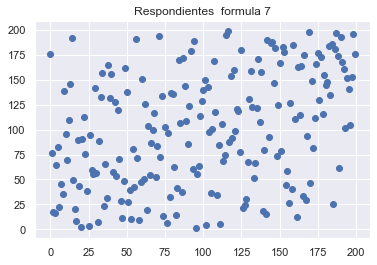

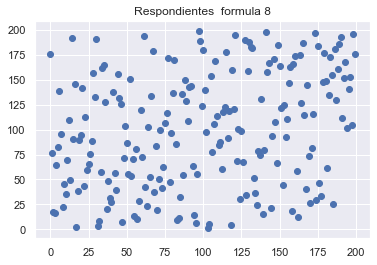

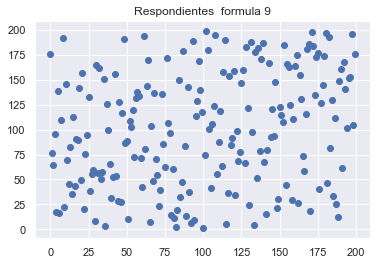

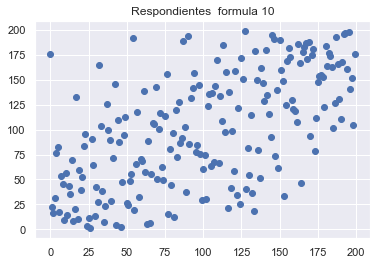

In [132]:
#---------------------------------------
# Fórmula para colaboratividad
#---------------------------------------


colaborativity_formulas={}
for i in range(11):
    colaborativity_formulas[i]=eval('colaborativity_formula_'+str(i))

for key in dfs.keys():
    print('Coherence of Colaborativity Formulas w.r.t. to variance in '+str(key))
    for i in range(len(colaborativity_formulas)):
        colab={}
        colaboration_results = colaborativity_formulas[i](dfs[key])

        #each varying parameter name maps
        #to a dictionary showing the collaboration i results
        #in the corresponding 200 graphs
        colab[key] = {colaboration_results[x]:x for x in range(200)} 
        order_colab = list(colab[key].keys())
        order_colab.sort()
        ratio=0
        for j in range(40):
            if colab[key][order_colab[j]]<101:
                ratio+=1
                
        print('Colab '+str(i)+': '+str(ratio/40))
        
        f = plt.figure()
        X = [ell for ell in range(200)]
        Y = [colab[key][order_colab[ell-1]] for ell in range(200)]
        plt.scatter(x=X, y=Y)
        plt.title(key+"  formula "+str(i))
    print('---------------------')